### Zepto Case Study

Things to keep in mind:

● You can only use signals that are available before the match starts, so team names, away/home etc is fair to use. Any info that happens during the match is a violation.  
● Use lots of exploratory analysis and graphs to get a sense for the data.  
● Follow a hypothesis based approach.

Submission/Output:
    
● Code up your solution from EDA to the final output with probabilities/graphs etc either as a R/Python file/notebook.  
● Upload the file/notebook to a git repository and share the link with us.  
● Points for effective storytelling and structured problem solving with
comments/explanations.  
● Get creativity in terms of visualization, approaches and statistical modeling.  
● Please also share a clean doc with explanation for approach and final outcome in terms
of the model used. Clearly state the what and why for the approach.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import itertools

%matplotlib inline

In [2]:
input_data = pd.read_csv('input_data.csv')

In [3]:
input_data.head(4)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82


In [4]:
len(input_data['HomeTeam'].unique())

20

In [5]:
input_data['Date'] = pd.to_datetime(input_data['Date'], format="%d/%m/%Y")

In [6]:
input_data = input_data.drop(['Div'], axis=1) #dropping first column 'Div' as value is always E0

### Total matched played

In [7]:
total_matches = input_data['Date'].count()
print('Total matches played - ' +str(total_matches))

Total matches played - 380


### Total teams

In [8]:
total_teams = input_data['HomeTeam'].unique()
total_teams_count = input_data['HomeTeam'].nunique()

print('Total teams which played: '+str(total_teams_count))
print('The teams are : '+str(total_teams))

Total teams which played: 20
The teams are : ['Brentford' 'Man United' 'Burnley' 'Chelsea' 'Everton' 'Leicester'
 'Watford' 'Norwich' 'Newcastle' 'Tottenham' 'Liverpool' 'Aston Villa'
 'Crystal Palace' 'Leeds' 'Man City' 'Brighton' 'Southampton' 'Wolves'
 'Arsenal' 'West Ham']


In [9]:
total_games_each_team = input_data['HomeTeam'].value_counts() + input_data['AwayTeam'].value_counts()
each_team_games = pd.DataFrame(total_games_each_team).sort_index(axis = 0) 
each_team_games.columns = ['Total Games']
each_team_games

,Total Games
Arsenal,38
Aston Villa,38
Brentford,38
Brighton,38
Burnley,38
Chelsea,38
Crystal Palace,38
Everton,38
Leeds,38
Leicester,38


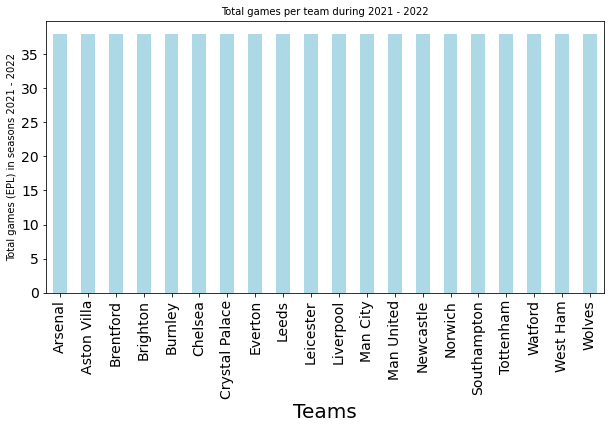

In [12]:
each_team_games.plot(kind='bar',color='lightblue', legend=False, figsize=(10,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Teams',fontsize=20)
plt.ylabel('Total games (EPL) in seasons 2021 - 2022',fontsize=10)
plt.title('Total games per team during 2021 - 2022',fontsize=10, color='black')
plt.show()

In [13]:
ten_season_teams = each_team_games[each_team_games['Total Games']==380]
ten_season_teams

,Total Games


In [14]:
one_season_teams = each_team_games[each_team_games['Total Games']==38]
one_season_teams

,Total Games
Arsenal,38
Aston Villa,38
Brentford,38
Brighton,38
Burnley,38
Chelsea,38
Crystal Palace,38
Everton,38
Leeds,38
Leicester,38


In [15]:
all_matches_results = pd.DataFrame(input_data['FTR'].value_counts())
all_matches_results

,FTR
H,163
A,129
D,88


Text(0.5, 1.0, 'Percentage share of match results')

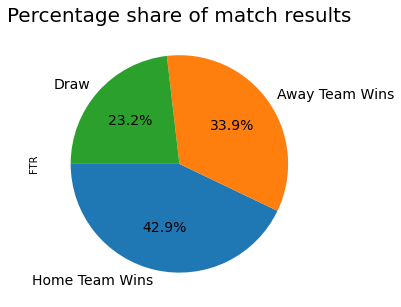

In [16]:
labels = ['Home Team Wins','Away Team Wins','Draw']

all_matches_results.plot(kind='pie', y = 'FTR', autopct='%1.1f%%', 
startangle=180, shadow=False, labels=labels, legend = False, fontsize=14, figsize=(5,5))

plt.title('Percentage share of match results',fontsize=20, color='black')

In [17]:
referees_count = input_data['Referee'].nunique()

print('Number of referees : '+str(referees_count))

all_referees = pd.DataFrame(input_data['Referee'].value_counts()).sort_index(axis = 0)

Number of referees : 22


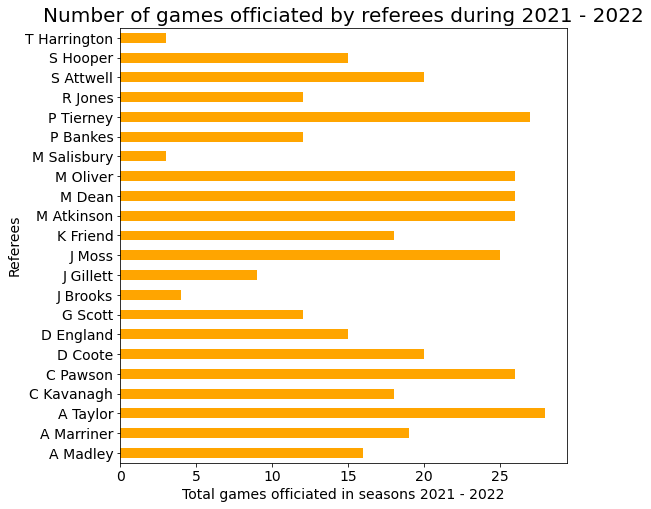

In [18]:
all_referees.plot(kind='barh',color='orange', legend=False, figsize=(8,8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Referees',fontsize=14)
plt.xlabel('Total games officiated in seasons 2021 - 2022',fontsize=14)
plt.title('Number of games officiated by referees during 2021 - 2022',fontsize=20, color='black')
plt.show()

Now, We need to focus on two columns 'HTR' and 'FTR'.

We need to look for two sets of data:

1. Away team winning at half time and Home team wins at full time.
2. Home team winning at half time and Away team wins at full time

In [19]:
come_backs = input_data[((input_data['HTR']=='A') & (input_data['FTR']=='H'))
                         | 
                         ((input_data['HTR']=='H') & (input_data['FTR']=='A'))]

come_back_wins = come_backs.shape[0]

print('Number of games in which teams loosing at half time come back to win the game at full time : '+str(come_back_wins))

Number of games in which teams loosing at half time come back to win the game at full time : 18


In [20]:
come_backs_year_sort = pd.DataFrame()
come_backs_year_sort['comeback_wins_per_year'] = come_backs['FTR'].groupby([come_backs.Date.dt.year]).agg('count')
come_backs_year_sort

,comeback_wins_per_year
Date,
2021,8
2022,10


## Team Level Analysis

### Home Goals scored by Teams

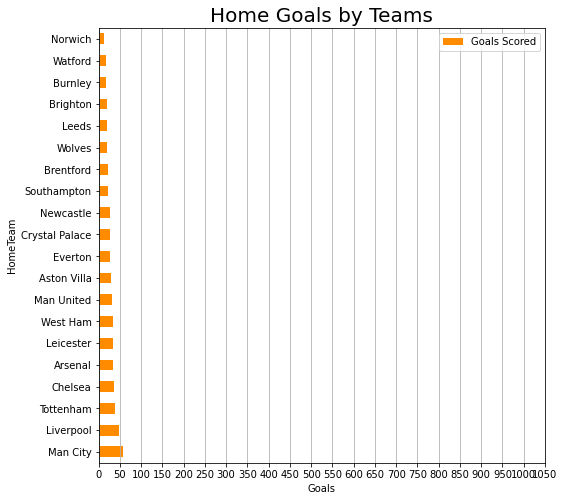

In [21]:
input_data.groupby('HomeTeam')['FTHG'].sum().sort_values(ascending=False).plot(kind='barh',figsize=(8,8),xticks=np.arange(0,1051,50),color='darkorange')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Home Goals by Teams",fontsize=20)
plt.legend(['Goals Scored'])

Observations :
1. Over the seasons Manchester City has scored most number of goals overall and at Home Ground.
2. Liverpool and Tottenham are at postion 2 and 3 respectively.
3. Norwich and Watford are the lowest goal scoring teams overall and at Home

### Away Goals scored by Teams

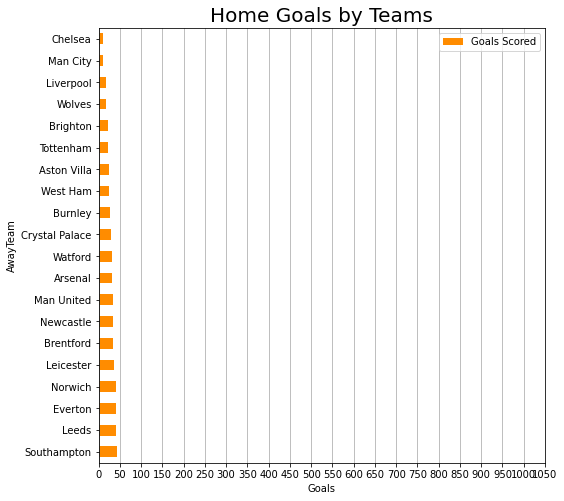

In [22]:
input_data.groupby('AwayTeam')['FTHG'].sum().sort_values(ascending=False).plot(kind='barh',figsize=(8,8),xticks=np.arange(0,1051,50),color='darkorange')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Home Goals by Teams",fontsize=20)
plt.legend(['Goals Scored'])

Observations :
1. Over the seasons Southampton has scored most number of goals at Away Grounds.
2. Leeds and Everton are at postion 2 and 3 respectively.
3. Chelsea and Manchester City are the lowest goal scoring teams at Away Grounds.

## Home Win Percentage

Text(0.5, 1.0, 'Home Ground Win %')

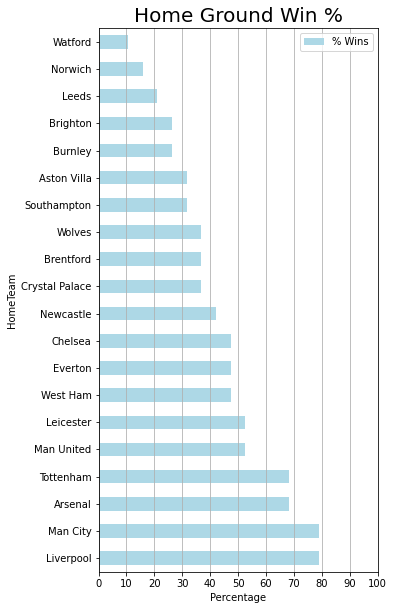

In [23]:
home_win=100*round((input_data.loc[input_data['FTR']=='H'].groupby('HomeTeam')['FTR'].count()/input_data.groupby('HomeTeam')['FTR'].count()),3)
home_win.sort_values(ascending=False).plot(kind='barh',figsize=(5,10),xticks=np.arange(0,101,10),color='lightblue')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Wins'])
plt.title("Home Ground Win %",fontsize=20)

Observations :
1. Over the seasons Liverpool and Man City has best Home Ground Win% of ~79% which means both have won almost 79/100 matches played at Home
2. Arsenal and Tottenham are at postion 2 and 3 respectively.
3. Watford has worst/least Home Ground Win % of ~10% which means the have won just 10/100 matches played at Home.

## Home Loss Percentage

Text(0.5, 1.0, 'Home Ground Loss %')

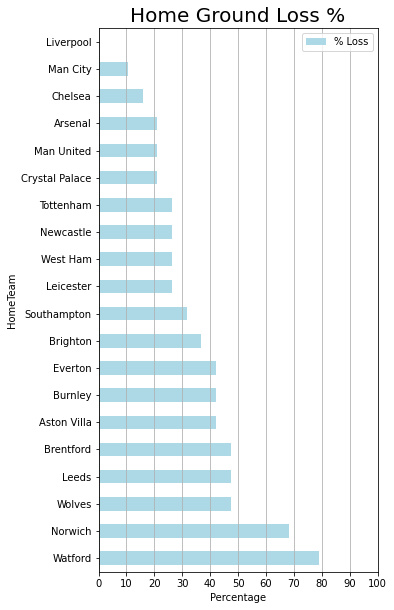

In [24]:
home_loss=100*round((input_data.loc[input_data['FTR']=='A'].groupby('HomeTeam')['FTR'].count()/input_data.groupby('HomeTeam')['FTR'].count()),3)
home_loss.sort_values(ascending=False).plot(kind='barh',figsize=(5,10),xticks=np.arange(0,101,10),color='lightblue')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Loss'])
plt.title("Home Ground Loss %",fontsize=20)

## Home Draw Percentage

Text(0.5, 1.0, 'Home Ground Draw %')

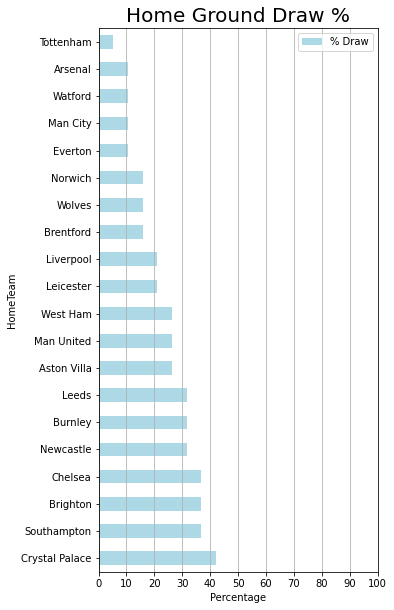

In [25]:
home_draw=100*round((input_data.loc[input_data['FTR']=='D'].groupby('HomeTeam')['FTR'].count()/input_data.groupby('HomeTeam')['FTR'].count()),3)
home_draw.sort_values(ascending=False).plot(kind='barh',figsize=(5,10),xticks=np.arange(0,101,10),color='lightblue')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Draw'])
plt.title("Home Ground Draw %",fontsize=20)

## Away Win Percentage

Text(0.5, 1.0, 'Away Ground Win %')

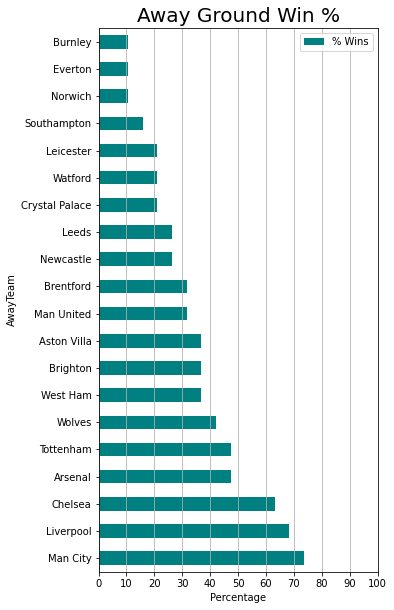

In [26]:
away_win=100*round((input_data.loc[input_data['FTR']=='A'].groupby('AwayTeam')['FTR'].count()/input_data.groupby('AwayTeam')['FTR'].count()),3)
away_win.sort_values(ascending=False).plot(kind='barh',figsize=(5,10),xticks=np.arange(0,101,10),color='teal')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Wins'])
plt.title("Away Ground Win %",fontsize=20)

## Away Loss Percentage

Text(0.5, 1.0, 'Away Ground Loss %')

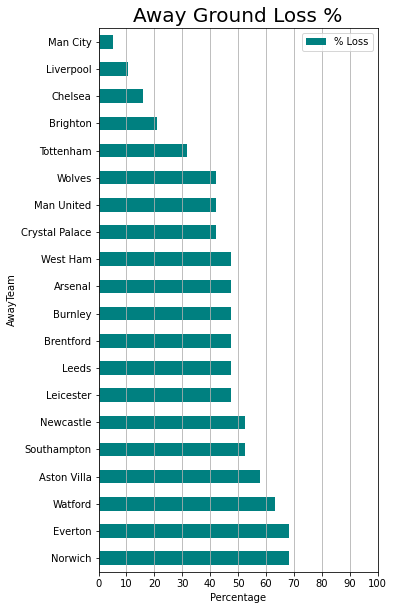

In [27]:
away_win=100*round((input_data.loc[input_data['FTR']=='H'].groupby('AwayTeam')['FTR'].count()/input_data.groupby('AwayTeam')['FTR'].count()),3)
away_win.sort_values(ascending=False).plot(kind='barh',figsize=(5,10),xticks=np.arange(0,101,10),color='teal')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Loss'])
plt.title("Away Ground Loss %",fontsize=20)

## Away Draw Percentage

Text(0.5, 1.0, 'Away Ground Draw %')

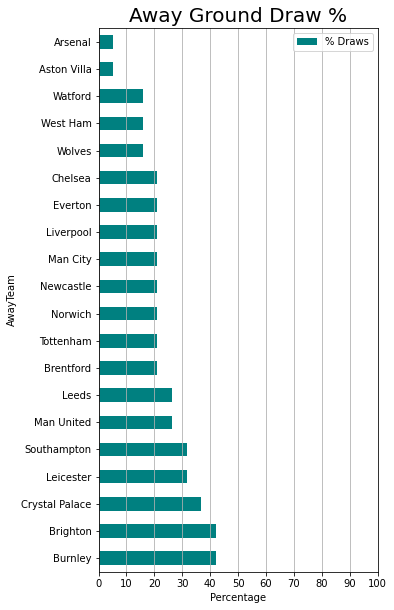

In [28]:
away_win=100*round((input_data.loc[input_data['FTR']=='D'].groupby('AwayTeam')['FTR'].count()/input_data.groupby('AwayTeam')['FTR'].count()),3)
away_win.sort_values(ascending=False).plot(kind='barh',figsize=(5,10),xticks=np.arange(0,101,10),color='teal')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Draws'])
plt.title("Away Ground Draw %",fontsize=20)

In [29]:
input_data['margin'] = input_data['FTHG'] - input_data['FTAG']
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'margin']

stat_correlations = input_data[stat_cols].corr()
stat_correlations['margin'].sort_values()

AST      -0.556878
AS       -0.447768
HY       -0.204951
AC       -0.200919
HR       -0.176560
HF       -0.043950
AY       -0.030736
AF       -0.010400
HC        0.176864
AR        0.177829
HS        0.441493
HST       0.555220
margin    1.000000
Name: margin, dtype: float64

<AxesSubplot:>

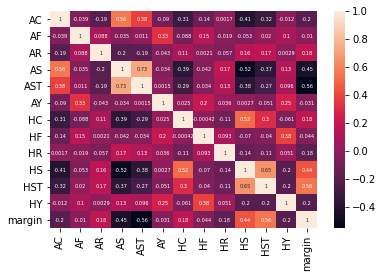

In [30]:
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 5})

In [31]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [32]:
#win rate for the home team

# Total number of matches.
n_matches = input_data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = input_data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(input_data[input_data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100


print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 380
Number of features: 105
Number of matches won by home team: 163
Win rate of home team: 42.89%


In [34]:
matches = input_data

In [35]:
matches.groupby(['HomeTeam', 'AwayTeam']).mean()

FTHG  FTAG  HTHG  HTAG  HS  AS  HST  AST  HF  AF  ...  \
HomeTeam AwayTeam                                                       ...   
Arsenal  Aston Villa     3     1     2     0  22  10    9    4  17  10  ...   
         Brentford       2     1     0     0  24   6    8    2  10   5  ...   
         Brighton        1     2     0     1  20   8    4    3  12  19  ...   
         Burnley         0     0     0     0  20  10    5    1   9  13  ...   
         Chelsea         0     2     0     2   6  22    3    5  10   4  ...   
...                    ...   ...   ...   ...  ..  ..  ...  ...  ..  ..  ...   
Wolves   Norwich         1     1     0     1  17  11    4    2   5  10  ...   
         Southampton     3     1     1     0   9  13    5   10  13  14  ...   
         Tottenham       0     1     0     1  25   8    6    6   9   7  ...   
         Watford         4     0     2     0  10   9    5    0  11  10  ...   
         West Ham        1     0     0     0  15   8    5    3   6   9  ...   

                      AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
HomeTeam AwayTeam                                                       
Arsenal  Aston Villa -0.50      2.03      1.90   2.04   1.89     2.11   
         Brentford   -1.00      1.93      1.97   1.91   2.01     2.06   
         Brighton    -0.75      1.78      2.13   1.83   2.11     1.87   
         Burnley     -1.50      1.92      2.01   1.93   2.00     1.93   
         Chelsea      0.50      2.02      1.91   2.00   1.93     2.07   
...                    ...       ...       ...    ...    ...      ...   
Wolves   Norwich     -1.00      1.93      1.97   1.96   1.94     1.96   
         Southampton -0.25      2.08      1.82   2.09   1.85     2.25   
         Tottenham    0.00      2.03      1.90   2.02   1.91     2.11   
         Watford     -0.50      1.98      1.95   1.97   1.95     1.98   
         West Ham     0.25      1.81      2.09   1.84   2.10     1.93   

                      MaxCAHA  AvgCAHH  AvgCAHA  margin  
HomeTeam AwayTeam                                        
Arsenal  Aston Villa     1.96     1.99     1.88       2  
         Brentford       2.01     1.97     1.90       1  
         Brighton        2.14     1.83     2.06      -1  
         Burnley         2.11     1.90     1.98       0  
         Chelsea         1.93     2.02     1.87      -2  
...                       ...      ...      ...     ...  
Wolves   Norwich         2.13     1.89     1.99       0  
         Southampton     1.96     2.05     1.84       2  
         Tottenham       1.92     2.02     1.86      -1  
         Watford         1.99     1.93     1.95       4  
         West Ham        2.13     1.83     2.06       1  

[380 rows x 99 columns]

In [36]:
h2h = matches.groupby(['HomeTeam', 'AwayTeam']).mean()
matches.groupby(['HomeTeam', 'AwayTeam']).get_group(('Arsenal', 'Chelsea'))

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,margin
18,2021-08-22,16:30,Arsenal,Chelsea,0,2,A,0,2,A,...,0.5,2.02,1.91,2.0,1.93,2.07,1.93,2.02,1.87,-2


In [37]:
# epl and championship teams home and away form last season
home_form = matches.groupby(['HomeTeam']).mean()
away_form = matches.groupby(['AwayTeam']).mean()
home_form.loc['Leeds'], away_form.loc['Leeds']

(FTHG        1.000000
 FTAG        2.000000
 HTHG        0.421053
 HTAG        0.842105
 HS         13.894737
              ...    
 MaxCAHH     2.017368
 MaxCAHA     2.041053
 AvgCAHH     1.923158
 AvgCAHA     1.965789
 margin     -1.000000
 Name: Leeds, Length: 99, dtype: float64,
 FTHG        2.157895
 FTAG        1.210526
 HTHG        1.000000
 HTAG        0.421053
 HS         16.210526
              ...    
 MaxCAHH     2.025263
 MaxCAHA     2.040000
 AvgCAHH     1.942105
 AvgCAHA     1.943158
 margin      0.947368
 Name: Leeds, Length: 99, dtype: float64)

#### Football is an unpredictable game; a goal can come at any point during the game, with no regard for past goals, teams, or other circumstances. Did I say "random?" Poisson Distribution is a statistical distribution that is used to determine the probabilities of randomly occuring occurrences.

#### Is it true, for example, that two goals are scored on average per game? If that's the case, what are the possibilities of seeing two goals in a game? Our saviour arrives. Given that we feed it with the expectation of events occuring, the Poisson distribution lets us find the probability of witnessing 'n' events (read 'n' objectives) in a defined time period.

In [38]:
from scipy.stats import poisson
from glob import glob

In [39]:
# modeling - get score function
home = 'Man City'
away = 'Chelsea'

def get_score(home, away):
    # head to head results in last 5 seasons
    home_mean = h2h.loc[(home, away)][0]
    away_mean = h2h.loc[(home, away)][1]
    
    # simulate score by random sampling from parametrized Poisson distribution
    home_score = poisson.rvs(home_mean, size=1)[0]
    away_score = poisson.rvs(away_mean, size=1)[0]

    return (home_score, away_score)

get_score(home, away)

(1, 0)

In [40]:
# helper function returns match result (home win, away win, draw)
def get_result(home_score, away_score):
    if home_score > away_score:
        result = 'H'
    elif home_score < away_score:
        result = 'A'
    else:
        result = 'D'
    return result

get_result(2,1)

'H'

In [41]:
# Taking Sample team name for testing the scoring method
home = 'Liverpool'
away = 'Leeds'
trials = 10000

def get_scores(home, away):
    # if head to head results exists
    try:
        home_mean = h2h.loc[(home, away)][0]
        away_mean = h2h.loc[(home, away)][1]

    # if head to head results unavailable
    except KeyError:
        # home and away form last season
        home_scored = home_form.loc[home]['FTHG']
        home_conceded = home_form.loc[home]['FTAG']
        away_scored = away_form.loc[away]['FTAG']
        away_conceded = away_form.loc[away]['FTHG']
        
        # average over goals for and against each team
        home_mean = (home_scored + away_conceded) / 2
        away_mean = (away_scored + home_conceded) / 2

    # simulate score by random sampling from parametrized Poisson distribution
    home_scores = poisson.rvs(home_mean, size=trials, random_state=2).astype(str)
    away_scores = poisson.rvs(away_mean, size=trials, random_state=0).astype(str)
    
    # get most probable scoreline and outcome with associated probabilities
    scores = pd.DataFrame(data={'home':home_scores, 'away':away_scores})
    scores['result'] = scores['home'] + '-' + scores['away']
    score_predictions = scores['result'].value_counts()
    score_probability = round(score_predictions / trials * 100, 1)
    scores['outcome'] = scores.apply(lambda x: get_result(x.home, x.away), axis=1)
    outcome_predictions = scores['outcome'].value_counts()
    outcome_probability = round(outcome_predictions / trials * 100, 1)
  
    return score_predictions.index[0], score_probability[0], outcome_predictions.index[0], outcome_probability[0]
    
get_scores(home, away)

('6-0', 16.7, 'H', 99.7)

In [46]:
input_data['HomeTeam'].unique()

array(['Brentford', 'Man United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham'],
      dtype=object)

In [48]:
input_data['AwayTeam'].unique()

array(['Arsenal', 'Leeds', 'Brighton', 'Crystal Palace', 'Southampton',
       'Wolves', 'Aston Villa', 'Liverpool', 'West Ham', 'Man City',
       'Burnley', 'Newcastle', 'Brentford', 'Everton', 'Norwich',
       'Watford', 'Man United', 'Tottenham', 'Chelsea', 'Leicester'],
      dtype=object)

In [47]:
input_data.shape

(380, 106)

In [60]:
# data analysis 
home_teams = ['Brentford', 'Man United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham']
away_teams = ['Arsenal', 'Leeds', 'Brighton', 'Crystal Palace', 'Southampton',
       'Wolves', 'Aston Villa', 'Liverpool', 'West Ham', 'Man City',
       'Burnley', 'Newcastle', 'Brentford', 'Everton', 'Norwich',
       'Watford', 'Man United', 'Tottenham', 'Chelsea', 'Leicester']

week1 = pd.DataFrame(data={'Home':home_teams, 'Away':away_teams})

In [61]:
week1['Pred. Score'] = week1.apply(lambda x: get_scores(x.Home, x.Away)[0], axis=1)
week1['Probability'] = week1.apply(lambda x: get_scores(x.Home, x.Away)[1], axis=1).map('{:,.1f}%'.format)
week1['Pred. Result'] = week1.apply(lambda x: get_scores(x.Home, x.Away)[2], axis=1)
week1['Prob. (%)'] = week1.apply(lambda x: get_scores(x.Home, x.Away)[3], axis=1).map('{:,.1f}%'.format)

In [62]:
input_data.columns

Index(['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA',
       'AvgCAHH', 'AvgCAHA', 'margin'],
      dtype='object', length=106)

In [63]:
input_data_1 = input_data[
    ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR']
]

In [64]:
input_data_1['Home'] = input_data_1['HomeTeam']  
input_data_1['Away'] = input_data_1['AwayTeam']  

<ipython-input-64-f137811c3511>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_1['Home'] = input_data_1['HomeTeam']
<ipython-input-64-f137811c3511>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_1['Away'] = input_data_1['AwayTeam']


In [65]:
merged_data= week1.merge(input_data_1, on=["Home","Away"])

In [68]:
merged_data[merged_data['Pred. Result']!=merged_data['FTR']]

,Home,Away,Pred. Score,Probability,Pred. Result,Prob. (%),HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
13,Leeds,Everton,2-2,7.9%,H,40.1%,Leeds,Everton,2,2,D,1,1,D
16,Southampton,Man United,1-0,14.0%,H,34.8%,Southampton,Man United,1,1,D,1,0,H
